<a href="https://colab.research.google.com/github/FFI-Vietnam/camtrap-tools/blob/main/MegaDetector/confusion_matrix/02_create-confusion-matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This script evaluates recall accuracy of MegaDetector from a ground-truth dataset
and a result json file. Then it creates a set of visualization of recall values 
on each group of species.

After runnning this script, a 'results' folder is created

results
    |__ 
    
"""

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# specifies Colab directories and file names
root = '/content/drive/'

dataset_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/dataset'
WI_folder = 'My Drive/FFI/Wildlife Insights Bulk Upload Test/bulk-upload_template-autofill/data cleaning'
ground_truth_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/ground-truths'

ground_truth_file_name = '01_ground-truth-table_Kon-Plong.csv'
MD_result_file_name = 'MegaDetector_result_2021-08-27.json'
# taxon match table is generated using Wildlife Insights/bulk-upload/04_collect-WI-taxon-database.ipynb script
# it is saved as 4.1_collect_WI-taxon-database.csv
taxon_match_table_file_name = '4.1_collect_WI-taxon-database.csv'

In [4]:
# read and save file functions
def read_csv_Google_drive(root, contain_folder, file_name):
  file_path = os.path.join(root, contain_folder, file_name)
  return pd.read_csv(file_path)

def save_csv_Google_drive(df, root, contain_folder, file_name):
  """
  function to save a csv file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'image_metadata(2020-06-26)_full.csv'
  """
  # save file to Colab runtime storage (will be deleted when this notebook is closed)
  df.to_csv('dataframe.csv', index=False)

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  with open('dataframe.csv', 'r') as f:
    df_file = f.read()

  with open(file_path, 'w') as f:
    f.write(df_file)

  print(f'File is saved to {file_name} in Google Drive at {file_path}')

In [12]:
# read ground-truth table
ground_truth_table = read_csv_Google_drive(root, ground_truth_folder, ground_truth_file_name)
ground_truth_table[~ ground_truth_table.species_common_name.isna()].head(50)

,FileName,species_common_name,datetime_created,batch_group
0,100__67096__2019-04-22__15-09-11(1).JPG,Human,2019-04-22 15:09:11,0
1,100__67096__2019-04-22__15-09-42(2).JPG,Human,2019-04-22 15:09:42,1
2,100__67096__2019-04-22__15-12-32(1).JPG,Human,2019-04-22 15:12:32,2
3,100__67096__2019-04-22__15-12-55(2).JPG,Human,2019-04-22 15:12:55,3
4,100__67096__2019-04-22__15-13-18(1).JPG,Human,2019-04-22 15:13:18,4
5,100__67096__2019-04-22__15-14-06(1).JPG,Human,2019-04-22 15:14:06,5
6,100__67096__2019-04-22__15-14-47(2).JPG,Human,2019-04-22 15:14:47,6
7,100__67096__2019-04-22__15-15-23(1).JPG,Human,2019-04-22 15:15:23,7
8,100__67096__2019-04-24__09-55-44(1).JPG,Yellow-throated Marten,2019-04-24 09:55:44,8
9,100__67096__2019-04-24__09-55-46(2).JPG,Yellow-throated Marten,2019-04-24 09:55:46,8


In [7]:
# read MegaDetector result
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

# print sample result
mega_result['images'][5]

{'detections': [{'bbox': [0.5825, 0.9118, 0.4078, 0.08803],
   'category': '1',
   'conf': 0.849},
  {'bbox': [0.003062, 0.8421, 0.1527, 0.1578],
   'category': '1',
   'conf': 0.214}],
 'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/100/67096/100__67096__2019-04-27__12-50-26(3).JPG',
 'max_detection_conf': 0.849}

In [8]:
# read taxon_match_table
taxon_match_table = read_csv_Google_drive(root, WI_folder, taxon_match_table_file_name)
taxon_match_table.sample(5)

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name
34,2014519,Aves,Passeriformes,Leiotrichidae,Garrulax,milleti,"Robinson & Kloss, 1919",Black-hooded Laughingthrush,biological,068b5c86-d844-4182-866f-75cf6eae4ae7,Black-hooded Laughingthrush
48,2015156,Aves,Passeriformes,Muscicapidae,Kittacincla,malabarica,"Scopoli, 1788",White-rumped Shama,biological,aa8579dc-5b25-4347-b1ac-31668aede87b,White-rumped Shama
12,2013885,Aves,Passeriformes,Pycnonotidae,Alophoixus,ochraceus,"Moore, 1854",NaN,biological,624c99ad-48fc-48d0-b534-c02c5bef2889,Ochraceous Bulbul
55,2014343,Aves,Passeriformes,Timaliidae,Pomatorhinus,ruficollis,"Hodgson, 1836",Streak-breasted Scimitar Babbler,biological,7d77768f-90ce-4274-8054-5d80d5ba4fd8,Streak-breasted Scimitar Babbler
10,2008596,Aves,Strigiformes,Strigidae,Glaucidium,cuculoides,"Vigors, 1831",Asian Barred Owlet,biological,4c73f9a9-63fc-463f-a7a4-dae475074bc4,Asian Barred Owlet


In [ ]:
def list_labels(in_batch=True, mega_result, ground_truth_table, threshold):
  """
  list actual labels and prediction labels
  @params in_batch: accounts for images in batch. For example if 3 images in a 
                    batch has 3 animals, but MD could detect only one, that 
                    would be enough to be a correct detection.
  @return: a list of actual labels and a list of predection labels
  """

  def has_any_object_in_batch(detection_batch, threshold, category_id):
    for detection in detection_batch:
      for i in range(len(detection)):
        if detection[i]['conf'] > threshold and detection[i]['category'] == category_id:
          return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  list_of_MD_filename = []
  for i in range(len(mega_result['images'])):
    list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  # get number of batches
  num_batch = ground_truth_table['batch_group'].nunique()

  y_actu = []
  y_pred = []

  if in_batch:
    num_row = num_batch
    column_in_search = ground_truth_table['batch_group']
    column_name = 'batch_group'
  else:
    num_row = len(mega_result['images'])
    column_in_search = ground_truth_table['FileName']
    column_name = 'FileName'

  """
  treat each batch as an image
  # in case batch is blank
  if all rows are blank:
    if all predictions are blank:
      actu.append('Blank')
      pred.append('Blank')
    if there is at least one animal in predictions:
      actu.append('Blank')
      pred.append('Animal')

  # in case batch is not blank
  if there are n distinct animals, e.g. Human and Domestic Dog:
    for each distinct animal
      if any of that animal is correctly detected:
        actu.append(distinct_animal)
        pred.append(animal)
      else:
        actu.append(distinct_animal)
        pred.append('Blank')
  """
  if not in_batch:
    for i in range(num_row):
      sub_table = ground_truth_table[ground_truth_table[column_name] == column_in_search.iat[i]]
      for j in range(len(sub_table)):

        filenames = sub_table['FileName'].to_list()
        # store list of detections for the batch
        detection_batch = []
        for f in filenames:
          detection = mega_result['images'][list_off_MD_filename.index(f)]
          detection_batch.append(detection)

        # if all rows are blank
        if sub_table['species_common_name'].isnull().sum() == len(sub_table):
          if has_any_object_in_batch(detection_batch, threshold, 2):
            actu.append('Blank')
            pred.append('Human')
          elif has_any_object_in_batch(detection_batch, threshold, 1):
            actu.append('Blank')
            pred.append('Animal')
          else:
            actu.append('Blank')
            pred.append('Blank')
        # if there is at least one detection event
        else:
          # list n distinct animal detections
          distinct_animals = sub_table['species_common_name'].unique()
          for animal in distinct_animals:
            if animal == 'Human':
              if has_any_object_in_batch(detection_batch, threshold, 2):
                actu.append('Human')
                pred.append('Human')
              else:
                actu.append('Human')
                pred.append('Blank')
            else:
              if has_any_object_in_batch(detection_batch, threshold, 1):
                actu.append(animal)
                pred.append(animal)
              else:
                actu.append(animal)
                pred.append('Blank')

      # try:
      #   # actual label
      #   actu = ground_truth_table[ground_truth_table['FileName'] == files[i]]['species_common_name'].iat[0]

      #   # prediction label
      #   # if the image has any animal
      #   if has_object(mega_result['images'][i]['detections'], threshold, '1'):
      #     if actu == '':
      #       y_pred.append('Animal')
      #       y_actu.append('Blank')
      #     else:
      #       y_pred.append('Animal')
      #       y_actu.append(actu)

      #   # if the image has any human
      #   if has_object(mega_result['images'][i]['detections'], threshold, '2'):
      #     y_pred.append('Human')
      #     if actu == '':
      #       y_actu.append('Blank')
      #     else:
      #       y_actu.append(actu)

      #   # if not have any human or animal
      #   if (not has_object(mega_result['images'][i]['detections'], threshold, '1')) and (not has_object(mega_result['images'][i]['detections'], threshold, '2')):
      #     y_pred.append('Blank')
      #     if actu == '':
      #       y_actu.append('Blank')
      #     else:
      #       y_actu.append(actu)    
      # except:
      #   # print('File not found', files[i])
      #   pass
  
  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred


In [18]:
ground_truth_table['species_common_name'].nunique()

141

In [ ]:
def create_confusion_matrix(y_actu, y_pred):
  print('Generating confusion matrix...')

  y_actu = pd.Series(y_actu, name='Actual')
  y_pred = pd.Series(y_pred, name='Prediction')
  df_confusion = pd.crosstab(y_pred, y_actu, rownames=['Prediction'], colnames=['Actual'], margins=True)

  # normalized confusion matrix using:
  df_conf_norm = round(df_confusion / df_confusion.sum(axis=1), 2)

  # delete nan columns
  df_conf_norm.dropna(axis = 1, inplace=True)

  # drop unecessary columns
  df_conf_norm.drop(columns=['All'], inplace=True)

  # collapse columns
  confusion_matrix = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for col in df_confusion.columns:
    all = df_confusion[col]['All']
    animal = all - df_confusion[col]['Blank'] - df_confusion[col]['Human']
    human = df_confusion[col]['Human']
    blank = df_confusion[col]['Blank']
    total = animal + human + blank
    recall = 0
    # recall
    if col == 'Human':
      recall = human / total
    elif col == 'Blank':
      recall = blank / total
    else:
      recall = animal / total
    confusion_matrix[col] = [str(animal), str(human), str(blank), str(total), str(round(recall,2))]

  return confusion_matrix

In [ ]:
def get_taxonomical_class(species_common_name, taxon_match_table=taxon_match_table):
  """
  get taxonomical class level of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    taxon_class = row['class'].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return taxon_class

# test
get_taxonomical_class('Bird')

'Aves'

In [ ]:
def get_scientific_name(species_common_name, taxon_match_table):
  """
  get genus and species name of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    genus, species = row['genus'].iat[0], row['species'].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return genus, species

# test
get_scientific_name("Owston's Civet")

('Chrotogale', 'owstoni')

In [ ]:
def get_conservation_status(genus, species):
  """
  get consevation status of a species from IUCN red list API
  https://apiv3.iucnredlist.org/api/v3/docs#species-history-name
  """
  api_token = "eba8c1a83a9d25e8ff01b8acbfa153fe3317d90badd60e2ec1d87ac8b330fda6"
  response = requests.get(f"https://apiv3.iucnredlist.org/api/v3/species/history/name/{genus}%20{species}?token={api_token}")
  try:
    status = response.json()['result'][0]['category']
  except:
    print('     Can not find conservation status for', genus, species)
  return status

# test
get_conservation_status('Chrotogale', 'owstoni')

'Endangered'

In [ ]:
def visualize_recall_bargraph(taxon_class, confusion_matrix, THRESHOLD, taxon_match_table):
  """
  visualize recall values by bargraph by taxonomical class
  """

  print(f"Generating visualization plot for {taxon_class}...")
  total = []
  recall = []
  names = []

  image_count = len(mega_result['images'])

  data = confusion_matrix

  for species in data.columns[:-1]: # not include All 
    try:
      if get_taxonomical_class(species) in taxon_class:
        recall.append(data[species][4])
        total.append(data[species][3])
        names.append((species))
    except:
      pass

  recall_stats = pd.DataFrame({'name':names, 'recall':recall, 'total':total})
  recall_stats['recall'] = recall_stats['recall'].astype('float64')
  recall_stats['total'] = recall_stats['total'].astype('int')
  recall_stats.sort_values('recall', inplace=True, ascending=True)

  # creating the bar plot
  species_name = recall_stats['name'].to_list()
  values = recall_stats['recall'].to_list()
  total = recall_stats['total'].to_list()
  avg_recall = np.mean(recall_stats['recall'])

  colors = []
  color_map = {
               "Not Evaluated": "lightblue",
               "Data Deficient": "lightyellow",
               "Least Concern": "mediumseagreen",
               "Near Threatened": "olive",
               "Vulnerable": "orange",
               "Endangered": "orangered",
               "Critically Endangered": "maroon",
               "Extinct in the Wild": "black",
               "Extinct": "silver",
               "Unable to find status": "violet"
              }
  for name in species_name:
    try:
      genus, species = get_scientific_name(name, taxon_match_table)
      status = get_conservation_status(genus, species)
      colors.append(color_map[status])
    except:
      colors.append(color_map["Unable to find status"])

  fig = plt.figure(figsize=(10, 20))
    
  plt.barh(species_name, values, color=colors)
  for i, v in enumerate(values):
      plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')
      plt.text(v+0.07, i, f'{str(total[i])} images', color='blue', fontweight='bold')
  # for i, v in enumerate(total):

  plt.xlabel("Values")
  plt.ylabel("Species name")
  labels = list(color_map.keys())
  handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
  plt.legend(handles, labels)
  plt.title(f"Evaluate over {image_count} images \nclass: {taxon_class} \nthreshold:  {THRESHOLD} \naverage_recall_value: {round(avg_recall,2)}")
  # plt.savefig(f"123.png")
  plt.show()


In [ ]:
def recall_evaluation(THRESHOLD, taxon_class, ground_truth_table, mega_result, taxon_match_table, in_batch):
  y_actu, y_pred = list_labels(mega_result, ground_truth_table, THRESHOLD, in_batch)
  confusion_matrix = create_confusion_matrix(y_actu, y_pred)
  visualize_recall_bargraph(taxon_class, confusion_matrix, THRESHOLD, taxon_match_table)

110166 images
Generating actual and prediction lists...
Reduction rate 0.7772391117605821
Generating confusion matrix...
Generating visualization plot for ['Aves']...
     Can not find taxonomy info for Animal
     Can not find taxonomy info for Banded Krait
     Can not find taxonomy info for Black-throated Laughingthrush
     Can not find taxonomy info for Flying Insect
     Can not find taxonomy info for Hill Blue Flycatcher
     Can not find taxonomy info for Impressed Tortoise
     Can not find taxonomy info for Indochinese Wren-babbler
     Can not find taxonomy info for Small Asian Mongoose
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan


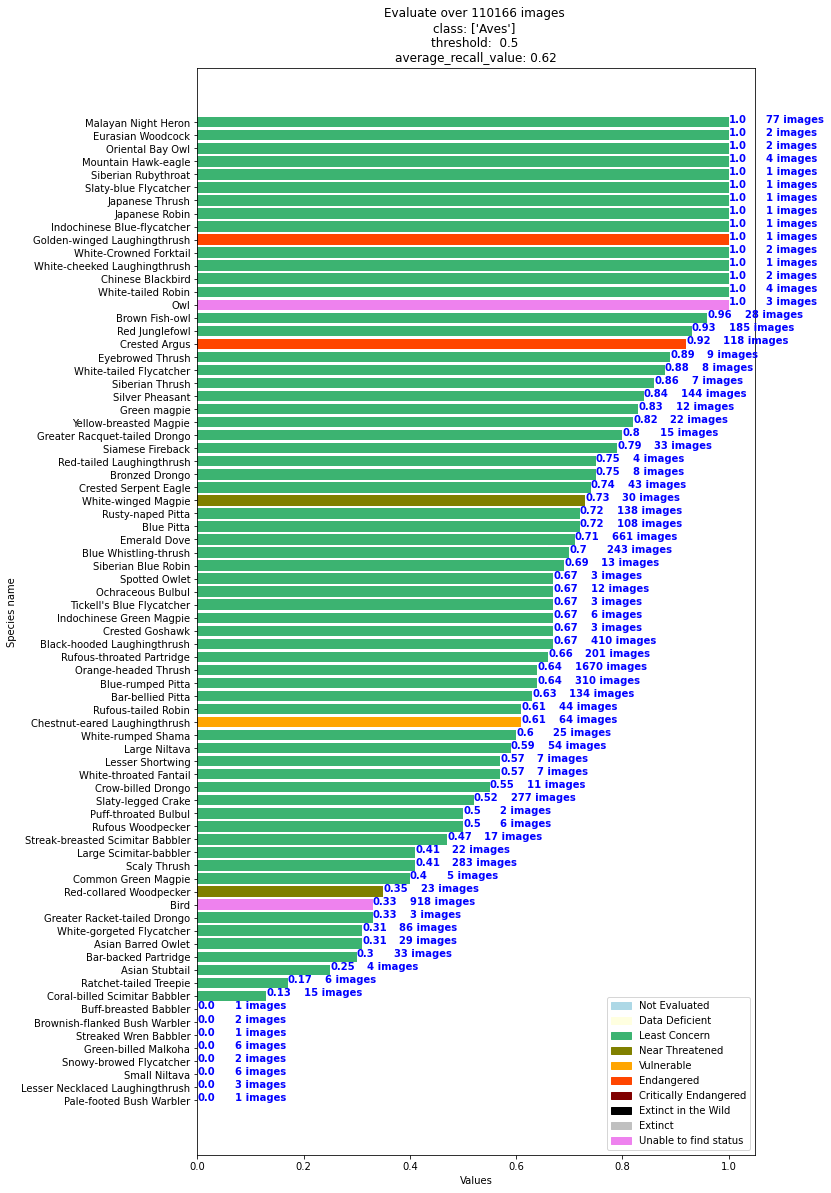

In [ ]:
# read files
ground_truth_table = read_csv_Google_drive(root, ground_truths_folder, ground_truth_file_name)
taxon_match_table = read_csv_Google_drive(root, WI_folder, taxon_match_table_file_name)
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

recall_evaluation(0.5, ['Aves'], ground_truth_table, mega_result, taxon_match_table, in_batch=True)

110166 images
Generating actual and prediction lists...
Reduction rate 0.7772391117605821
Generating confusion matrix...
Generating visualization plot for ['Mammalia', 'Insecta', 'Reptilia']...
     Can not find taxonomy info for Animal
     Can not find taxonomy info for Banded Krait
     Can not find taxonomy info for Black-throated Laughingthrush
     Can not find taxonomy info for Flying Insect
     Can not find taxonomy info for Hill Blue Flycatcher
     Can not find taxonomy info for Impressed Tortoise
     Can not find taxonomy info for Indochinese Wren-babbler
     Can not find taxonomy info for Small Asian Mongoose
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for Macaca nan
     Can not fi

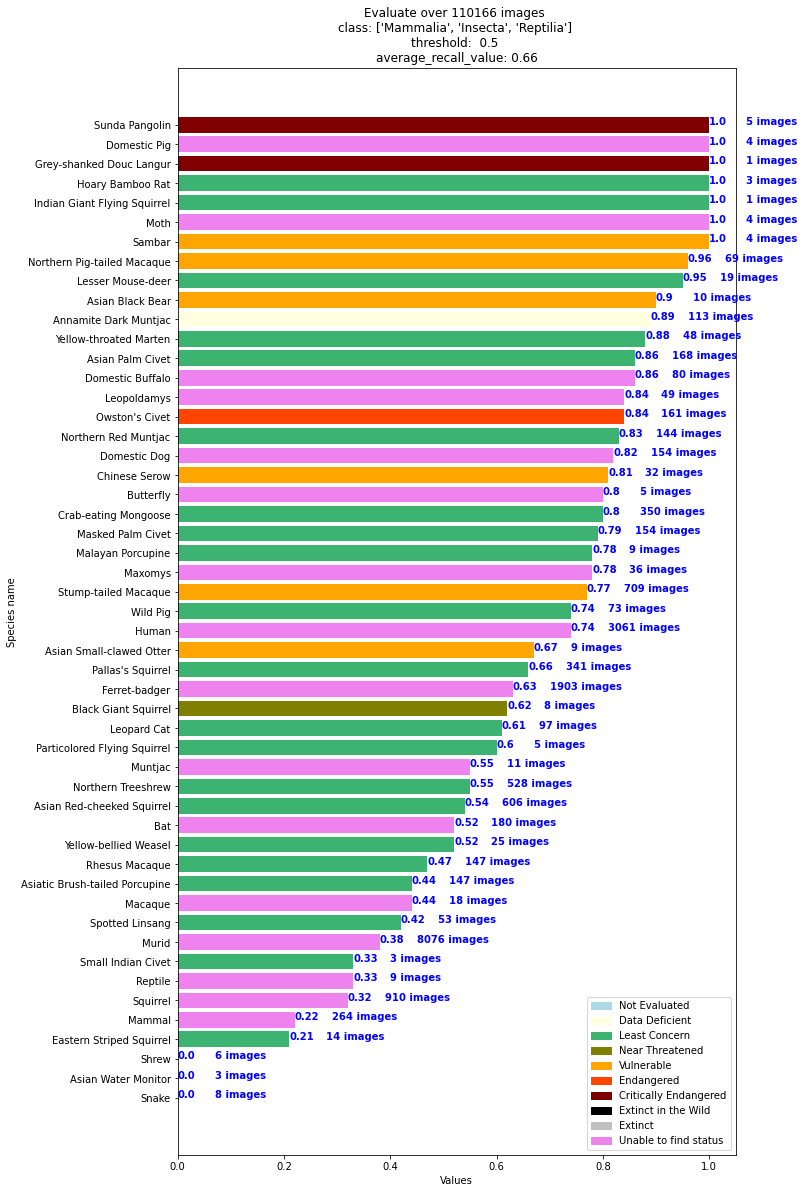

In [ ]:
recall_evaluation(0.5, ['Mammalia', 'Insecta', 'Reptilia'])